In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.preprocessing import image
from keras.models import Sequential
from keras.optimizers import SGD


In [ ]:
# convolution, dropout and max pool. layers added
opt = SGD(learning_rate = 0.001)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

from keras import regularizers

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,kernel_regularizer=regularizers.l2(1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# the final classification is done via fully connected layers
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()
# categorical crossentropy is used since there are 3 classes
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       7

In [ ]:
# image preprocessing 
train_datagen = image.ImageDataGenerator(
      rescale=1./256,
      shear_range=0.1, #0.2
      zoom_range=0.1, #0.2
      horizontal_flip=True,
      )
test_dataset = image.ImageDataGenerator(rescale=1./256)

In [ ]:
#Take the path to a directory
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset/training/',
    target_size = (256,256),
    color_mode = 'rgb',
    batch_size = 32, 
    class_mode= 'categorical'
)

Found 10615 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [ ]:
# take validation path to a directory
validation_generator = test_dataset.flow_from_directory(
    '/content/drive/MyDrive/dataset/validation/',
    target_size = (256,256),
    batch_size = 32, 
    class_mode = 'categorical'
)


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

#Configure the model for training
history = model.fit(train_generator,
                    steps_per_epoch=89, 
                    validation_data=validation_generator,
                    validation_steps=3, 
                    epochs=100,
         )


Found 4535 images belonging to 3 classes.
Epoch 1/100
89/89 [==============================] - 898s 10s/step - loss: 1.4397 - accuracy: 0.6451 - val_loss: 0.7431 - val_accuracy: 0.6875
Epoch 2/100
89/89 [==============================] - 638s 7s/step - loss: 0.6333 - accuracy: 0.7383 - val_loss: 0.5840 - val_accuracy: 0.7812
Epoch 3/100
89/89 [==============================] - 502s 6s/step - loss: 0.5516 - accuracy: 0.7794 - val_loss: 0.6446 - val_accuracy: 0.7396
Epoch 4/100
89/89 [==============================] - 372s 4s/step - loss: 0.5027 - accuracy: 0.8195 - val_loss: 0.6369 - val_accuracy: 0.7500
Epoch 5/100
89/89 [==============================] - 291s 3s/step - loss: 0.4935 - accuracy: 0.8154 - val_loss: 0.4713 - val_accuracy: 0.7917
Epoch 6/100
89/89 [==============================] - 242s 3s/step - loss: 0.4581 - accuracy: 0.8467 - val_loss: 0.5211 - val_accuracy: 0.8021
Epoch 7/100
89/89 [==============================] - 188s 2s/step - loss: 0.4316 - accuracy: 0.8644 - val

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


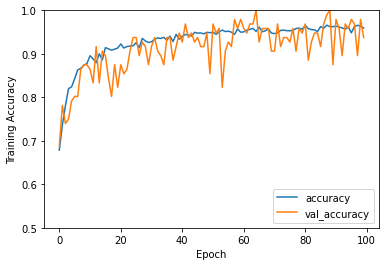

In [ ]:
print(history.history.keys())
# plot model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')



In [ ]:
# save the model
model.save("network.h5")
